# Введение

Интернет магазин "В один клик" обратился за помощью в построении моделей прогнозов. Магазин занимается различными бытовыми и электронными товарами. В последнее время снизилась активность клиентов. Возможный выход — удерживать активность постоянных клиентов. Магазин хочет сделать это с помощью персонализированных предложений.

### Цели и задачи

Разделим и промаркируем на два вида активности - "прежний уровень", "снизилась". 

Нужно собрать данные по клиентам по следующим группам:

    Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    Сюда входят признаки: 
      - Тип сервиса;
      - Решение на сообщения;
      - Маркетинг на 6 месяцев;
      - Маркетинг текущего месяца;
      - Длительность истории с клиентом.
    
    Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    Следующие признаки:
      - Наиболее частая категория заказов;
      - Среднее число просматриваемых категории продуктов за визит;
      - Число неоплаченных продуктов в корзине за 3 месяца.
      
    Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
      - Время за прошлый год;
      - Время на сайте за предущий месяц;
      - Время на сайте за текущий месяц;
      - Минут за визит;
      - Число страниц за визит;
      - Сбои сайта.
      
    Признаки, которые описывают финансовое поведение покупателя на сайте.
      - Разница в выручке предыдущего месяца;
      - Разница в выручке текущего и предыдущего месяцев;
      - Выручка в текущем месяце.

Цели:

    1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца;
    
    2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца;
    
    3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения. 
    

### Решение

Проведем следующие действия:

- Загрузка, осмотр, проверка входящих датасетов;
- Предобработка данных: удаление дубликатов, пропусков, исправление искажений данных;
- Исследовательский анализ данных. Составление графиков;
- Объединение таблиц;
- Корреляционный анализ;
- Создание пайплайнов;
- Анализ важности признаков;
- Сегментация покупателей;
- Общий вывод.

В процессе работы будут сделаны промежуточные выводы по каждому действию

# Загрузка, осмотр, проверка входящих датасетов

Загрузка библиотек, модулей и компонентов.

In [1]:
!pip install phik
!pip install -U scikit-learn
!pip install shap 
!pip install --upgrade pandas==1.2.4
!pip install --upgrade numpy==1.19.5

     |████████████████████████████████| 686 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 13.5 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 75.4 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 539 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 14.9 MB 1.1 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, mean_absolute_error, recall_score, precision_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import phik
import shap
from sklearn.dummy import DummyClassifier

Загружаем датасеты.

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv')

Теперь посмотрим на корректность загрузки данных

In [4]:
market_file.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
market_money.head(5)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
market_time.head(5)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [7]:
money.head(5)

,id;Прибыль
215348;0,98.0
215349;4,16.0
215350;3,13.0
215351;4,87.0
215352;4,21.0


Видим, что в некоторых файлах разделитель значений — точка с запятой, а разделитель десятичных значений — запятая.

Разделим слившуюся информацию разделителем и заменим запятую на точку.

In [8]:
money = pd.read_csv('/datasets/money.csv', sep=';')
money['Прибыль'] = (money['Прибыль'].str.replace(',', '.'))
money

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
...,...,...
1295,216643,4.44
1296,216644,6.11
1297,216645,3.29
1298,216646,4.03


Теперь данные корректны. Изучим информацию о датасетах.

In [9]:
def info_f (dataset):
    return print(dataset.info(), '\n')

info_f(market_file)
info_f(market_money)
info_f(market_time)
info_f(money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Единственная проблема в типе данных находится в последнем датасете, в колонке Прибыль. Численные значения имеют тип object. Исправим это в предобработке данных.

### Вывод по осмотру данных

Данные корректны, кроме разделителя и запятой в дробном значений. В остальном все датасеты имеют корректное отображение, в том числе по типу данных. В каждом датасете разное количество строк.

# Предобработка данных

Изменим типы данных в датасете money.

In [10]:
def convertion_to_float(val):
    return float(val)

money['Прибыль'] = money['Прибыль'].apply(convertion_to_float)
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Теперь проведем поиск дубликатов

In [11]:
def doubles(val):
    return print(val.loc[val.duplicated()], '\n')

doubles(market_file)
doubles(market_money)
doubles(market_time)
doubles(money)

Empty DataFrame
Columns: [id, Покупательская активность, Тип сервиса, Разрешить сообщать, Маркет_актив_6_мес, Маркет_актив_тек_мес, Длительность, Акционные_покупки, Популярная_категория, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал, Ошибка_сервиса, Страниц_за_визит]
Index: [] 

Empty DataFrame
Columns: [id, Период, Выручка]
Index: [] 

Empty DataFrame
Columns: [id, Период, минут]
Index: [] 

Empty DataFrame
Columns: [id, Прибыль]
Index: [] 



Дубликатов нет.

Ищем nan и пустые значения.

In [ ]:
def search_nan(val):
    return print(val.isna().sum(), '\n')

search_nan(market_file)
search_nan(market_money)
search_nan(market_time)
search_nan(money)

Пропусков нет.

Несколько столбцов в market_file не содержат нижнего подчеркивания, что может потом плохо сказаться на обработке. Исправим.

In [13]:
market_file = market_file.rename(columns={'Покупательская активность': 'Покупательская_активность', 
                                        'Тип сервиса': 'Тип_сервиса', 
                                        'Разрешить сообщать': 'Разрешить_сообщать', 
                                 })

Теперь проведем поиск уникальных значений в столбцах.

In [14]:
def unique_val(val):
    return print(val.value_counts(), '\n')

unique_val(market_file[['Покупательская_активность']])
unique_val(market_file[['Тип_сервиса']])
unique_val(market_file[['Разрешить_сообщать']])
unique_val(market_file[['Популярная_категория']])
unique_val(market_money[['Период']])
unique_val(market_time[['Период']])

Покупательская_активность
Прежний уровень              802
Снизилась                    498
dtype: int64 

Тип_сервиса
стандарт       914
премиум        376
стандартт       10
dtype: int64 

Разрешить_сообщать
да                    962
нет                   338
dtype: int64 

Популярная_категория                
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
dtype: int64 

Период             
предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1300
dtype: int64 

Период          
предыдцщий_месяц    1300
текущий_месяц       1300
dtype: int64 



Есть схожие слова. Скорректируем.

In [15]:
market_file['Тип_сервиса'] = (
    market_file['Тип_сервиса']
    .replace(['стандартт'], 'стандарт', regex=True)
) 

market_time['Период'] = (
    market_time['Период']
    .replace(['предыдцщий_месяц'], 'предыдущий_месяц', regex=True)
)

def unique_val(val):
    return print(val.value_counts(), '\n')

unique_val(market_file[['Покупательская_активность']])
unique_val(market_file[['Тип_сервиса']])
unique_val(market_file[['Разрешить_сообщать']])
unique_val(market_file[['Популярная_категория']])
unique_val(market_money[['Период']])
unique_val(market_time[['Период']])

Покупательская_активность
Прежний уровень              802
Снизилась                    498
dtype: int64 

Тип_сервиса
стандарт       924
премиум        376
dtype: int64 

Разрешить_сообщать
да                    962
нет                   338
dtype: int64 

Популярная_категория                
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
dtype: int64 

Период             
предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1300
dtype: int64 

Период          
предыдущий_месяц    1300
текущий_месяц       1300
dtype: int64 



### Вывод по предобработке данных

Данные оказались не сильно искажены.
Поменяли тип данных в одном из столбцов;
Дубликаты не найдены, нулевые значения не найдены;
Есть опечатки, ошибки в словах, было исправлено.

# Исследовательский анализ данных

Для проведения статистического анализа необходимо найти различные и важные параметры имеющихся данных

- Среднее арифметическое, медиана
- Дисперсия и стандартное отклонение
- Межквартильный размах
- Минимальные и максимальные значения, их разность

Кроме того, необходимо построить диаграммы рассеяния, размаха, линейные.

И нужно найти клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

Найдем медиану, среднее, дисперсию, стандартное отклонение, квартили, мин. и макс. значения.

In [16]:
def descr(val):
    return display(val.describe())

descr(market_file.drop(columns='id'))
descr(market_money.drop(columns='id'))
descr(market_time.drop(columns='id'))
descr(money.drop(columns='id'))


,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


,Выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


,Прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


Проанализируем результаты метода describe.

Датасет market_file:
Здесь нет ничего необычного, выбросов нет. Все значения укладываются в нормальную статистику.

Датасет market_money:
В данном датасете тоже все нормально. Хотя неизвестно, насколько нормальным является выручка с покупателся в 106 тысяч рублей.

Датасет market_time:
Аналогично, все в порядке.

Датасет money:
Все в порядке.

Найдем медиану датасетов.

In [17]:
def medi(val):
    return display(val.median())

medi(market_file.drop(columns='id'))
medi(market_money.drop(columns='id'))
medi(market_time.drop(columns='id'))
medi(money.drop(columns='id'))

Маркет_актив_6_мес                       4.20
Маркет_актив_тек_мес                     4.00
Длительность                           606.00
Акционные_покупки                        0.24
Средний_просмотр_категорий_за_визит      3.00
Неоплаченные_продукты_штук_квартал       3.00
Ошибка_сервиса                           4.00
Страниц_за_визит                         8.00
dtype: float64

Выручка    4957.5
dtype: float64

минут    13.0
dtype: float64

Прибыль    4.045
dtype: float64

Медианные значения практически совпадают со средним арифметическим, что является хорошим знаком.

Теперь дисперсию.

In [18]:
def var(val):
    return display(np.var(val).round(3))

var(market_file.drop(columns='id'))
var(market_money.drop(columns='id'))
var(market_time.drop(columns='id'))
var(money.drop(columns='id'))

Маркет_актив_6_мес                         1.029
Маркет_актив_тек_мес                       0.485
Длительность                           62380.144
Акционные_покупки                          0.062
Средний_просмотр_категорий_за_визит        1.836
Неоплаченные_продукты_штук_квартал         3.884
Ошибка_сервиса                             3.820
Страниц_за_визит                          15.813
dtype: float64

Выручка    3159421.566
dtype: float64

минут    16.642
dtype: float64

Прибыль    1.027
dtype: float64

Сумашедший разброс наблюдается у market_file в Длительности - 62380.144 и в market_money у Выручки - 3159421.566.
Позже на графиках взглянем на это.

Теперь найдем размах.

In [19]:
def range_i(val):
    return display(val.max()-val.min())

range_i(market_file[['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']])
range_i(market_money[['Выручка']])
range_i(market_time['минут'])
range_i(money['Прибыль'])

Маркет_актив_6_мес                       5.70
Маркет_актив_тек_мес                     2.00
Длительность                           969.00
Акционные_покупки                        0.99
Средний_просмотр_категорий_за_визит      5.00
Неоплаченные_продукты_штук_квартал      10.00
Ошибка_сервиса                           9.00
Страниц_за_визит                        19.00
dtype: float64

Выручка    106862.2
dtype: float64

19

6.569999999999999

Посчитаем межквартильный размах.

In [20]:
iqr_arr_1 = stats.iqr(market_file[['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']], axis=0)
print('market_file: \n')
print('Межквартильный размах столбца Маркет_актив_6_мес:', iqr_arr_1[0], 
      '\n', 'Межквартильный размах столбца Маркет_актив_тек_мес:', iqr_arr_1[1], 
      '\n', 'Межквартильный размах столбца Длительность:', iqr_arr_1[2], 
      '\n', 'Межквартильный размах столбца Акционные_покупки:', iqr_arr_1[3],
      '\n', 'Межквартильный размах столбца Средний_просмотр_категорий_за_визит:', iqr_arr_1[4],
      '\n', 'Межквартильный размах столбца Неоплаченные_продукты_штук_квартал:', iqr_arr_1[5],
      '\n', 'Межквартильный размах столбца Ошибка_сервиса:', iqr_arr_1[6],
      '\n', 'Межквартильный размах столбца Страниц_за_визит:', iqr_arr_1[7],)
print('\n')
iqr_arr_2 = stats.iqr(market_money[['Выручка']], axis=0)
print('market_money: \n')
print('Межквартильный размах столбца Выручка:', iqr_arr_2[0])
print('\n')
iqr_arr_3 = stats.iqr(market_time[['минут']], axis=0)
print('market_time: \n')
print('Межквартильный размах столбца минут:', iqr_arr_3[0])
print('\n')
iqr_arr_4 = stats.iqr(money[['Прибыль']], axis=0)
print('money: \n')
print('Межквартильный размах столбца Прибыль:', iqr_arr_4[0])

market_file: 

Межквартильный размах столбца Маркет_актив_6_мес: 1.2000000000000002 
 Межквартильный размах столбца Маркет_актив_тек_мес: 0.0 
 Межквартильный размах столбца Длительность: 400.5 
 Межквартильный размах столбца Акционные_покупки: 0.12999999999999998 
 Межквартильный размах столбца Средний_просмотр_категорий_за_визит: 2.0 
 Межквартильный размах столбца Неоплаченные_продукты_штук_квартал: 3.0 
 Межквартильный размах столбца Ошибка_сервиса: 3.0 
 Межквартильный размах столбца Страниц_за_визит: 6.0


market_money: 

Межквартильный размах столбца Выручка: 772.8500000000004


market_time: 

Межквартильный размах столбца минут: 6.0


money: 

Межквартильный размах столбца Прибыль: 1.37


### Графики

Теперь нужно визуализировать все данные которые мы получили. Начнем с диаграмм размаха.

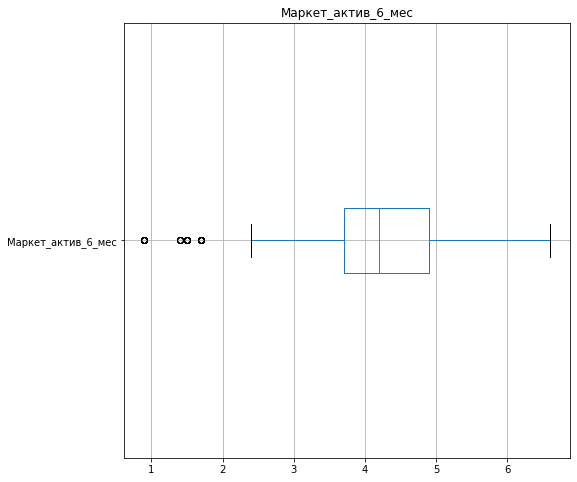

In [21]:
market_file['Маркет_актив_6_мес'].plot.box(figsize=(8, 8), title='Маркет_актив_6_мес', xlabel='Коммуникаций', vert=False, grid=True)

plt.show()

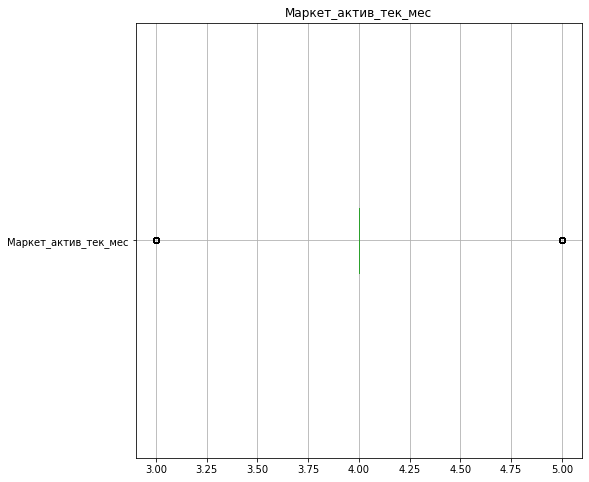

In [22]:
market_file['Маркет_актив_тек_мес'].plot.box(figsize=(8, 8), title='Маркет_актив_тек_мес', xlabel='Коммуникаций', vert=False, grid=True)

plt.show()

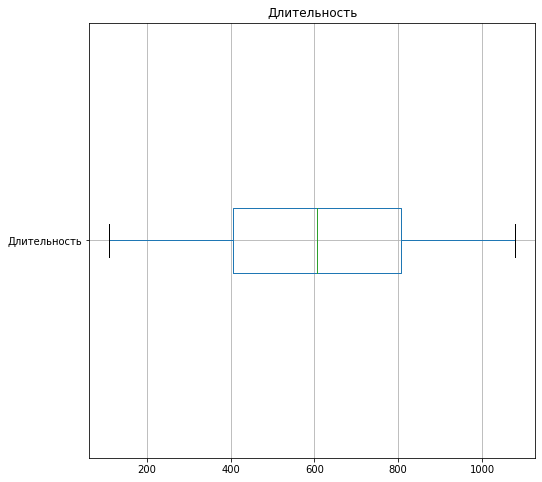

In [23]:
market_file['Длительность'].plot.box(figsize=(8, 8), title='Длительность', xlabel='Дней', vert=False, grid=True)

plt.show()

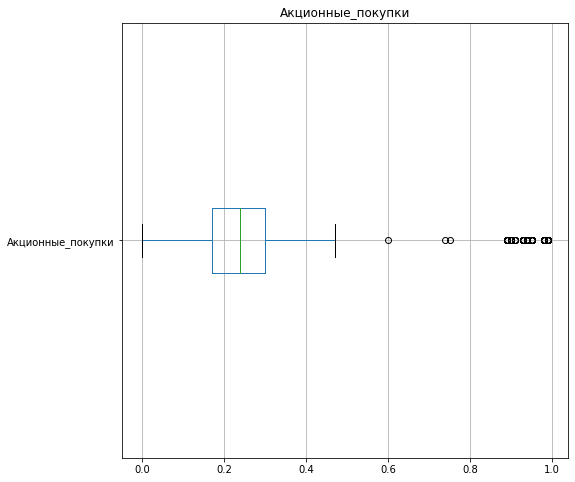

In [24]:
market_file['Акционные_покупки'].plot.box(figsize=(8, 8), title='Акционные_покупки', xlabel='Доля покупок', vert=False, grid=True)

plt.show()

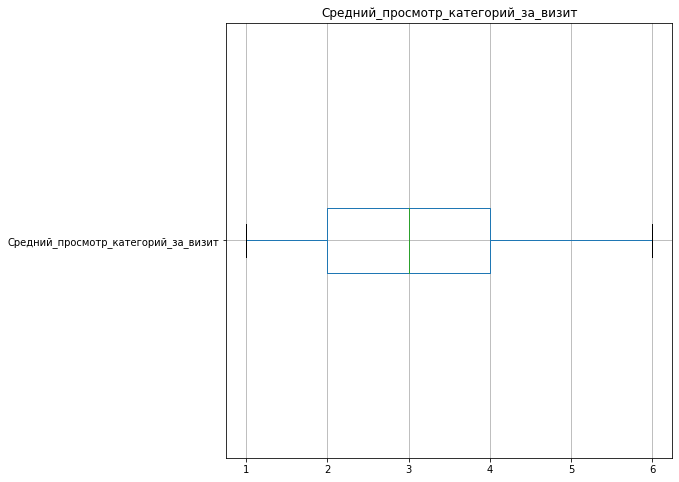

In [25]:
market_file['Средний_просмотр_категорий_за_визит'].plot.box(figsize=(8, 8), title='Средний_просмотр_категорий_за_визит', xlabel='Категории', vert=False, grid=True)

plt.show()

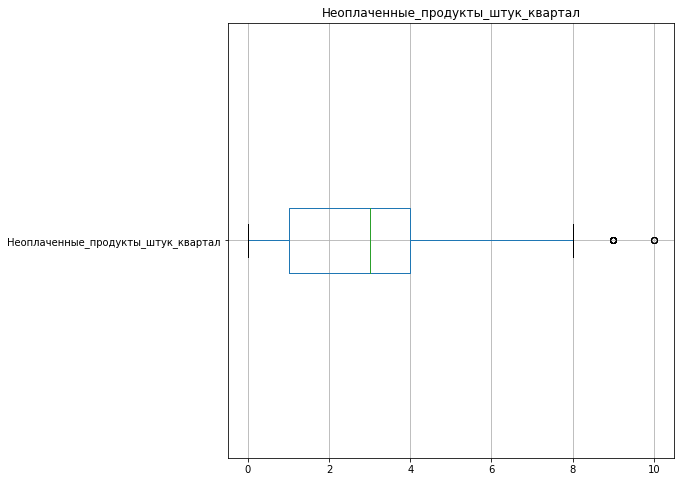

In [26]:
market_file['Неоплаченные_продукты_штук_квартал'].plot.box(figsize=(8, 8), title='Неоплаченные_продукты_штук_квартал', xlabel='Штук', vert=False, grid=True)

plt.show()

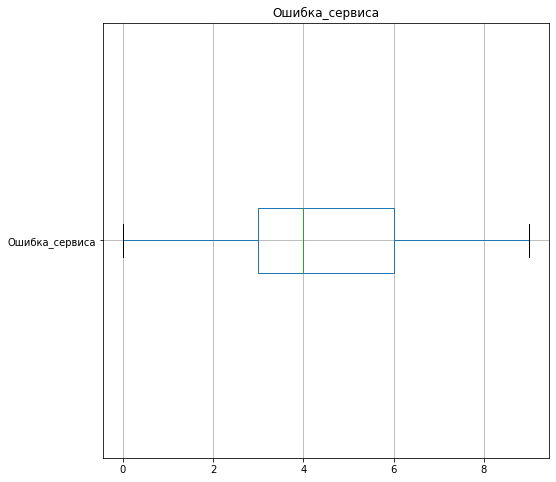

In [27]:
market_file['Ошибка_сервиса'].plot.box(figsize=(8, 8), title='Ошибка_сервиса', xlabel='Количество ошибок', vert=False, grid=True)

plt.show()

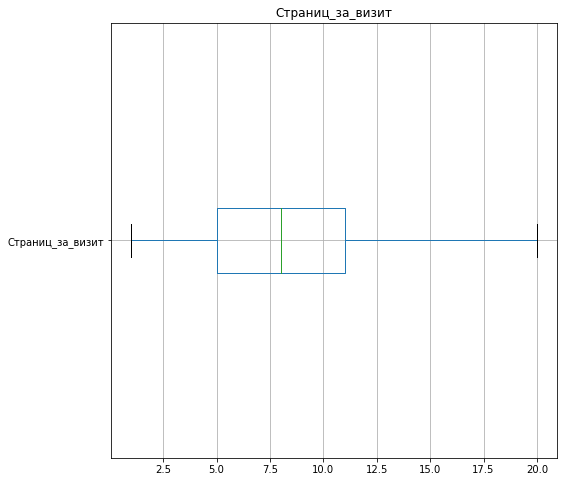

In [28]:
market_file['Страниц_за_визит'].plot.box(figsize=(8, 8), title='Страниц_за_визит', xlabel='Количество страниц', vert=False, grid=True)

plt.show()

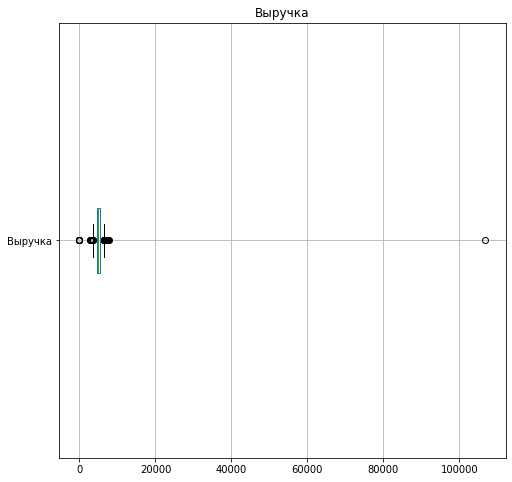

In [29]:
market_money['Выручка'].plot.box(figsize=(8, 8), title='Выручка', xlabel='рублей', vert=False, grid=True)

plt.show()

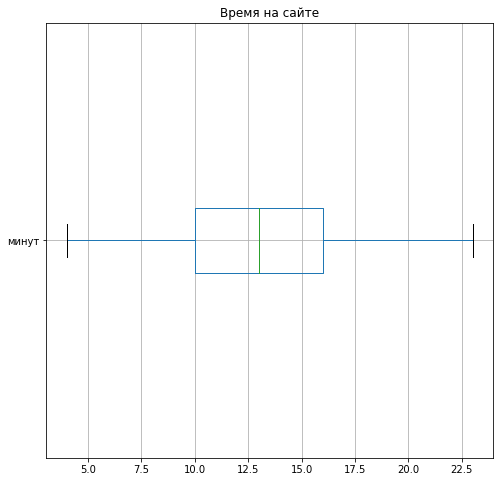

In [30]:
market_time['минут'].plot.box(figsize=(8, 8), title='Время на сайте', xlabel='минуты', vert=False, grid=True)

plt.show()

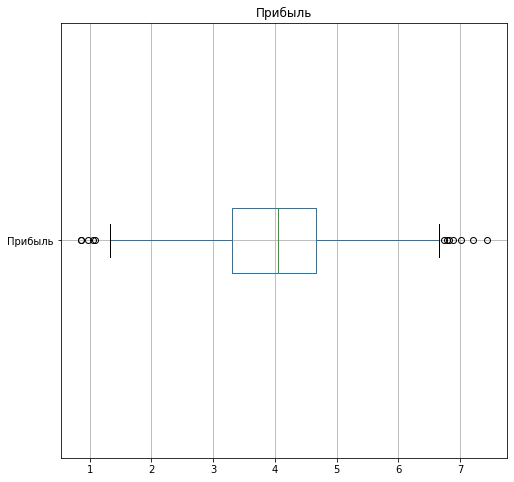

In [31]:
money['Прибыль'].plot.box(figsize=(8, 8), title='Прибыль', xlabel='рублей', vert=False, grid=True)

plt.show()

На диаграммах Маркет_актив_6_мес, Маркет_актив_тек_мес, Неоплаченные_продукты_штук_квартал есть незначительные выбросы.
На диаграммах Акционные_покупки, Прибыль этих выбросов достаточно много. Проанализируем их через гистограммы.
В столбце Выручка явный выброс, как мы и предполагали, сильно влияющий на статистические показатели. Нужно изменить него.

In [32]:
market_money.query('Выручка > 20000')

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Заменим на среднее значение по столбцу.

In [33]:
market_money['Выручка'].replace(106862.2, market_money['Выручка'].median(), inplace=True)
market_money.query('Выручка > 20000')

,id,Период,Выручка


Теперь построим гистограммы.

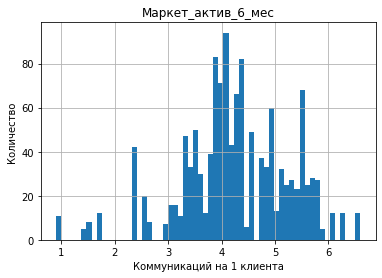

In [34]:
(market_file['Маркет_актив_6_мес']
 .hist(bins=60)
 .set_title('Маркет_актив_6_мес')
)

plt.xlabel('Коммуникаций на 1 клиента')
plt.ylabel('Количество');

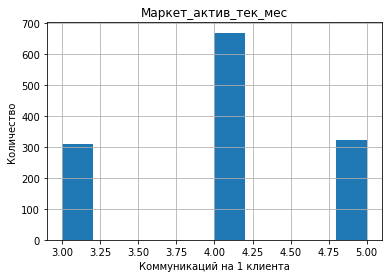

In [35]:
(market_file['Маркет_актив_тек_мес']
 .hist()
 .set_title('Маркет_актив_тек_мес')
)

plt.xlabel('Коммуникаций на 1 клиента')
plt.ylabel('Количество');

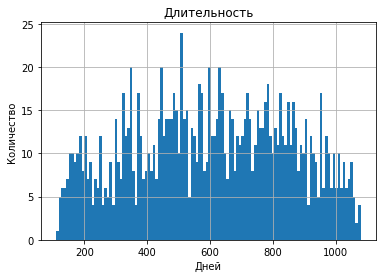

In [36]:
(market_file['Длительность']
 .hist(bins=120)
 .set_title('Длительность')
)

plt.xlabel('Дней')
plt.ylabel('Количество');

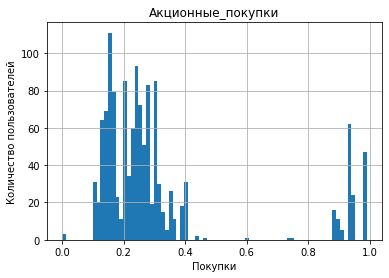

In [37]:
(market_file['Акционные_покупки']
 .hist(bins=80)
 .set_title('Акционные_покупки')
)

plt.xlabel('Покупки')
plt.ylabel('Количество пользователей');

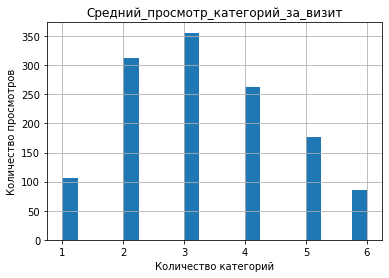

In [38]:
(market_file['Средний_просмотр_категорий_за_визит']
 .hist(bins=20)
 .set_title('Средний_просмотр_категорий_за_визит')
)

plt.xlabel('Количество категорий')
plt.ylabel('Количество просмотров');

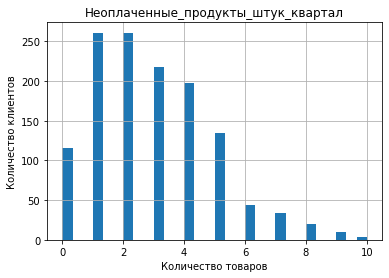

In [39]:
(market_file['Неоплаченные_продукты_штук_квартал']
 .hist(bins=30)
 .set_title('Неоплаченные_продукты_штук_квартал')
)

plt.xlabel('Количество товаров')
plt.ylabel('Количество клиентов');


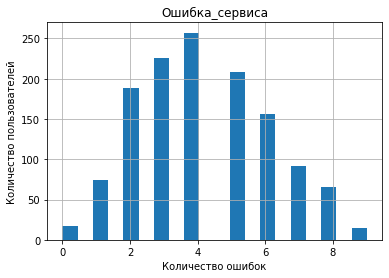

In [40]:
(market_file['Ошибка_сервиса']
 .hist(bins=20)
 .set_title('Ошибка_сервиса')
)

plt.xlabel('Количество ошибок')
plt.ylabel('Количество пользователей');


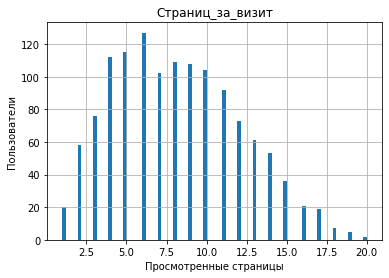

In [41]:
(market_file['Страниц_за_визит']
 .hist(bins=80)
 .set_title('Страниц_за_визит')
)

plt.xlabel('Просмотренные страницы')
plt.ylabel('Пользователи');

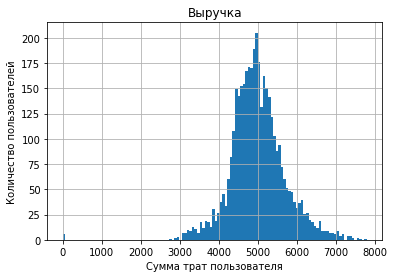

In [42]:
(market_money['Выручка']
 .hist(bins=120)
 .set_title('Выручка')
)

plt.xlabel('Сумма трат пользователя')
plt.ylabel('Количество пользователей');

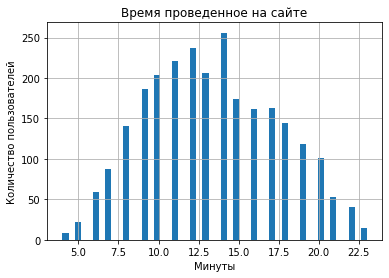

In [43]:
(market_time['минут']
 .hist(bins=50)
 .set_title('Время проведенное на сайте')
)

plt.xlabel('Минуты')
plt.ylabel('Количество пользователей');


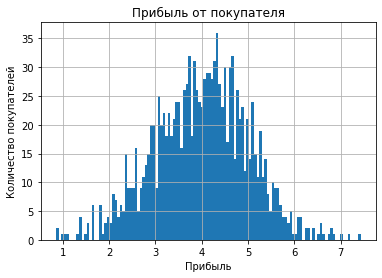

In [44]:
(money['Прибыль']
 .hist(bins=120)
 .set_title('Прибыль от покупателя')
)

plt.xlabel('Прибыль')
plt.ylabel('Количество покупателей');

Сделаем диаграммы для категориальных признаков.

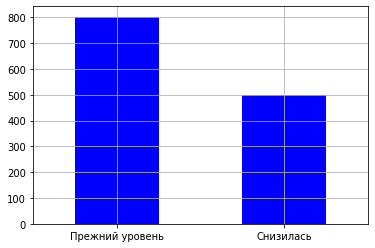

In [45]:
market_file['Покупательская_активность'].value_counts().plot.bar(color='blue', stacked=True, grid=True, rot=0);

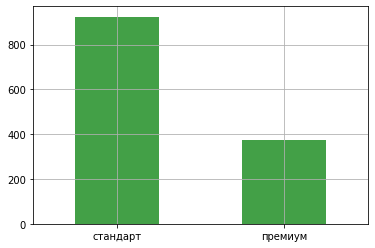

In [46]:
market_file['Тип_сервиса'].value_counts().plot.bar(color='#43a047', stacked=True, grid=True, rot=0);

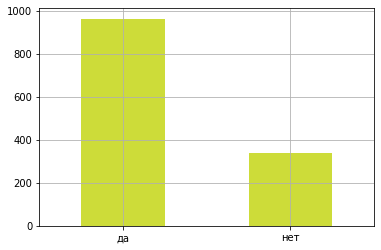

In [47]:
market_file['Разрешить_сообщать'].value_counts().plot.bar(color='#cddc39', stacked=True, grid=True, rot=0);

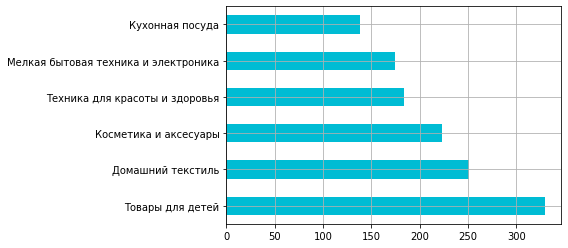

In [48]:
market_file['Популярная_категория'].value_counts().plot.barh(color='#00bcd4', stacked=True, grid=True, rot=0);

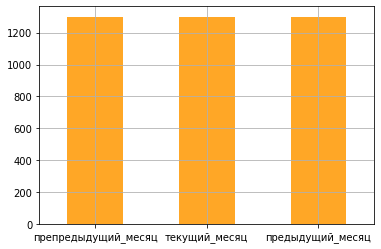

In [49]:
market_money['Период'].value_counts().plot.bar(color='#ffa726', stacked=True, grid=True, rot=0);

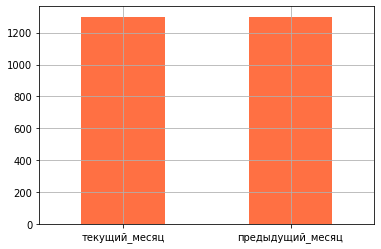

In [50]:
market_time['Период'].value_counts().plot.bar(color='#ff7043', stacked=True, grid=True, rot=0);

### Исследование

Начнем исследование с датасета market_file, пройдемся по каждому столбцу. Всего в датасете 13 столбцов, 9 количественных и 4 категориальных переменных. Два столбца с количественными - непрерывные. Остальные дискретные.

Столбец Маркет_актив_6_мес

    Имеет среднее арифметическое 4.25 и медиану 4.2. Это хорошие показатели, они почти равные.
    Дисперсия 1.029, низкая. Данные не слишком разнородны. Стандартное отклонение 1.01.
    Минимальное и максимальное значения - 0.9 и 6.6 соответственно, размах 5.7.
    Межвартильный размах 1.20.

Есть некоторые выбросы, согласно графику размаха. "Усы" показывают небольшую степень разброса, это видно и по гистограмме. В целом гистограмма почти правильные очертания вершины купола, что так же говорит о низкой дисперсии.

Столбец Маркет_актив_тек_мес

    Имеет среднее арифметическое 4.01 и медиану 4. Это хорошие показатели, они почти равные.
    Дисперсия 0.48, очень низкая. Стандартное отклонение 0.69.
    Минимальное и максимальное значения - 3.0 и 5.0 соответственно, размах 2.
    Межвартильный размах 0.

Очень низкая дисперсия


Столбец Длительность

    Имеет среднее арифметическое 601 и медиану 606. Это хорошие показатели, они почти равные.
    Дисперсия 62380, крайне высокая. Данные очень разнородны. Стандартное отклонение 249.
    Минимальное и максимальное значения - 110 и 1079 соответственно, размах 969.
    Межвартильный размах 400.

На ящике с учами выбросов нет. Гистограмма не имеет купола, разорвана по всей оси. Это говорит об очень высокой дисперсии.


Столбец Акционные покупки

    Имеет среднее арифметическое 0.31 и медиану 0.24. Это хорошие показатели, они почти равные.
    Дисперсия 0.062, низкая. Стандартное отклонение 0.24.
    Минимальное и максимальное значения - 0 и 0.99 соответственно, размах 0.99.
    Межвартильный размах 0.129.

Диаграмма размаха показывает выбросы с правой стороны. Медиана практически посередине ящик. Гистограмма показывает провал посреди графика. Дисперсия низкая.


Столбец Средний_просмотр_категорий_за_визит

    Имеет среднее арифметическое 0.31 и медиану 0.24. Это хорошие показатели, они почти равные.
    Дисперсия 0.062, низкая. Стандартное отклонение 0.24.
    Минимальное и максимальное значения - 0 и 0.99 соответственно, размах 0.99.
    Межвартильный размах 0.129.

Диаграмма размаха показывает выбросы с правой стороны. Медиана практически посередине ящика. Гистограмма показывает провал посреди графика. Дисперсия низкая.


Столбец Неоплаченные продукты_штук_квартал

    Имеет среднее арифметическое 2.84 и медиану 3. Это хорошие показатели, они почти равные.
    Дисперсия 3.88, низкая. Стандартное отклонение 1.97.
    Минимальное и максимальное значения - 0 и 10 соответственно, размах 10.
    Межвартильный размах 3.

Диаграмма размаха показывает выбросы с правой стороны и небольшой сдвиг влево. Гистограмма достаточно правильный график нормального распределения. Дисперсия низкая.


Столбец Ошибка сервиса

    Имеет среднее арифметическое 4.18 и медиану 4. Это хорошие показатели, они почти равные.
    Дисперсия 3.82, низкая. Стандартное отклонение 1.95.
    Минимальное и максимальное значения - 0 и 9 соответственно, размах 9.
    Межвартильный размах 3.

Диаграмма размаха показывает не имеет выбросов, почти симметрична. Гистограмма имеет форму нормального распределения. Дисперсия низкая.


Столбец Ошибка сервиса

    Имеет среднее арифметическое 8.17 и медиану 8. Это хорошие показатели, они почти равные.
    Дисперсия 15.18, средняя. Стандартное отклонение 3.97.
    Минимальное и максимальное значения - 1 и 20 соответственно, размах 19.
    Межвартильный размах 6.

Диаграмма размаха показывает не имеет выбросов, почти симметрична. Гистограмма имеет форму нормального распределения. Дисперсия средняя.

Столбец **Покупательская активность**

    Не изменилось 800 строк, снизилась 500.
    
Столбец **Тип сервиса**

    Стандарт 924 строк, премиум 376.
    
Столбец **Разрешить сообщать**

    Разрешать 962 строк, не разрешать 338.

Столбец **Популярная категория**

    Товары для детей                        330
    Домашний текстиль                       251
    Косметика и аксесуары                   223
    Техника для красоты и здоровья          184
    Мелкая бытовая техника и электроника    174
    Кухонная посуда                         138
    

Теперь разберем датасет market_money. В нем всего три столбца, 1 с категориальными значениями и два с количествеными. Один из них непрерывный.

Измерим заново данные столбца Выручка, так как мы меняли выброс на среднее в одной из строк.

In [51]:
iqr_arr_5 = stats.iqr(market_money[['Выручка']], axis=0)
print('Межквартильный размах столбца Выручка:', iqr_arr_5)

print('Размах: ', market_money[['Выручка']].max() - market_money[['Выручка']].min())

print('Дисперсия:', np.var(market_money[['Выручка']]))

print('Медиана:', market_money[['Выручка']].median())

display(market_money[['Выручка']].describe())

Межквартильный размах столбца Выручка: [772.85]
Размах:  Выручка    7799.4
dtype: float64
Дисперсия: Выручка    499592.951613
dtype: float64
Медиана: Выручка    4957.25
dtype: float64


,Выручка
count,3900.000000
mean,4999.566641
std,706.909531
min,0.000000
25%,4590.150000
50%,4957.250000
75%,5363.000000
max,7799.400000


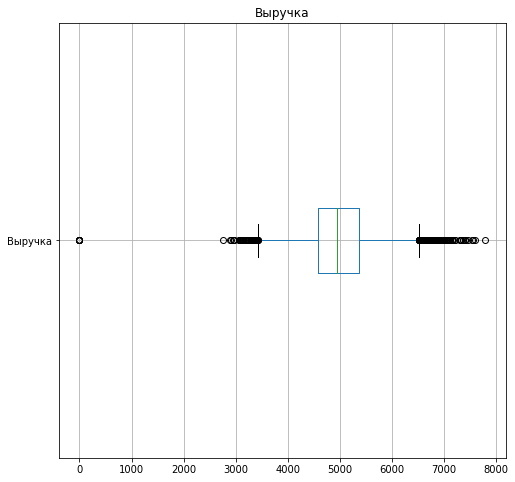

In [52]:
market_money['Выручка'].plot.box(figsize=(8, 8), title='Выручка', xlabel='рублей', vert=False, grid=True)

plt.show()

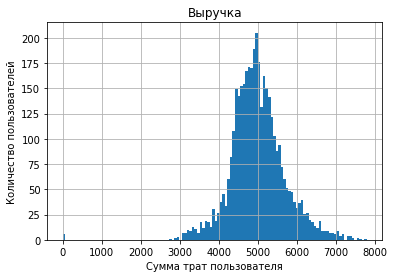

In [53]:
(market_money['Выручка']
 .hist(bins=120)
 .set_title('Выручка')
)

plt.xlabel('Сумма трат пользователя')
plt.ylabel('Количество пользователей');

Столбец **Выручка**

    Имеет среднее арифметическое 4999 и медиану 4957. Это хорошие показатели, они почти равные.
    Дисперсия 499595, низкая. Стандартное отклонение 706.
    Минимальное и максимальное значения - 0 и 7799 соответственно, размах 7799.
    Межвартильный размах 3.

Диаграмма размаха показывает огромной количество выбросов. Гистограмма достаточно правильный график нормального распределения. Дисперсия очень высокая.

Столбец **Период**

    предыдущий_месяц    2600
    текущий_месяц       1300
    


Теперь датасет market_time. Тут так же три столбца, 1 с категориальными значениями и два с количествеными. Один из них непрерывный.

Столбец **минут**

    Имеет среднее арифметическое 13.33 и медиану 13. Это хорошие показатели, они почти равные.
    Дисперсия 16.42, низкая. Стандартное отклонение 4.08.
    Минимальное и максимальное значения - 4 и 23 соответственно, размах 19.
    Межвартильный размах 6.

Диаграмма размаха практически идеальный ящик с усами. Гистограмма достаточно правильный график нормального распределения. Дисперсия низкая.

Столбец **Период**

    предыдущий_месяц    1300
    текущий_месяц       1300



И наконец датасет money. В нем два столбца, один количественный дискретный и один количественный непрерывный.

Столбец **Прибыль**

    Имеет среднее арифметическое 3.99 и медиану 4.05. Это хорошие показатели, они почти равные.
    Дисперсия 1.02, низкая. Стандартное отклонение 1.01.
    Минимальное и максимальное значения - 0.86 и 7.43 соответственно, размах 6.56.
    Межвартильный размах 1.37.

Диаграмма размаха практически идеальный ящик с усами, но показывает определенные выбросы справа и слева. Гистограмма достаточно правильный график нормального распределения. Дисперсия низкая.


### Вывод по статистическому исследованию 

Часть данных в датафрейме market_file имеет низкую дисперсию, низкий разброс. В датасете market_money столбцев Выручки имеет очень высокую дисперсию и разнородность данных. В целом ничего особенного нет во всех датасетах.

Теперь выполним одну из задач исследования, отберем тех клиентов, кто что-либо покупал и был активен в последние три месяца. Для этого используем фильтрацию для датасета market_file.
Основными признаками активности возьмем низкое количество неоплаченных продуктов в корзине за последние три месяца, покупательская активность и количество просмотренных страниц за визит.

In [54]:
avtive_customers = market_file.query('Неоплаченные_продукты_штук_квартал < 2 and Покупательская_активность == "Прежний уровень"')

Удалим из датасета пользователей не имевших покупок, в любой из последних трех месяцев.

In [55]:
market_money = market_money[~(market_money['Выручка'] == 0)]
market_money.query('Выручка == 0')

,id,Период,Выручка


# Объединение таблиц

Объединим файлы market_file.csv, market_money.csv, market_time.csv в одну таблицу.

Развернем датасеты.

In [56]:
market_time = pd.pivot_table(market_time, index=["id"], columns='Период', values="минут")
market_money = pd.pivot_table(market_money, index=["id"], columns='Период', values="Выручка")
market_time

Период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [57]:
df = market_file.merge(market_money, on='id', how='outer')
df.head(5)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5


Первые два соединились без ошибок.

In [58]:
df = df.merge(market_time, on='id', how='outer')
df.head(5)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


Датасеты соединились без ошибок. Переименуем новые столбцы.

In [59]:
df = df.rename(columns={'предыдущий_месяц_x': 'Выручка_предыдущий_месяц', 
                                        'препредыдущий_месяц': 'Выручка_препредыдущий_месяц', 
                                        'текущий_месяц_x': 'Выручка_текущий_месяц',
                                        'предыдущий_месяц_y': 'минут_предыдущий_месяц',
                                        'текущий_месяц_y': 'минут_текущий_месяц'
                                 
                                 })
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Теперь нужно заполнить значения None на нули.

In [60]:
df.fillna(0, inplace=True)

df = df[~(df['Выручка_предыдущий_месяц'] == 0)]

In [61]:
df.query('Выручка_предыдущий_месяц == 0')

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц


### Вывод по объединению

Таблицы объединены без ошибок, пустые значения не найдены.

In [62]:
df.shape

(1297, 18)

# Корреляционный анализ

Приступим к выявлению зависимостей между признаками. Построим матрицу корреляции для df.

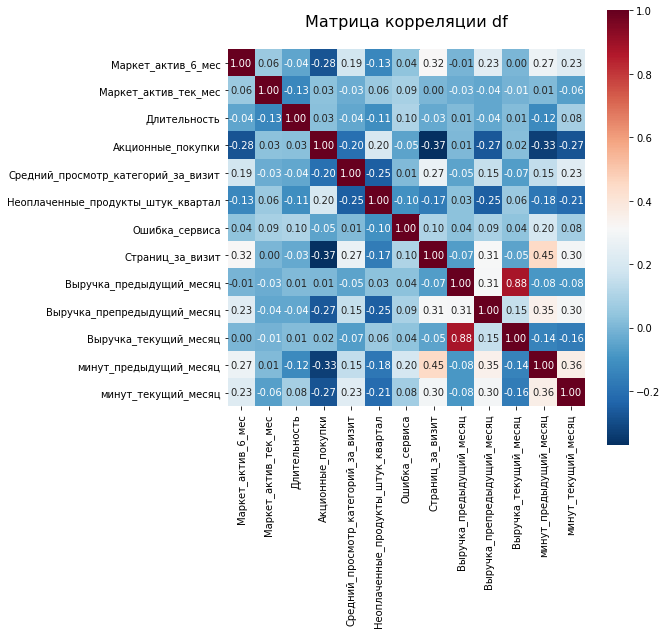

In [63]:
df_dropid = df.drop(['id'], axis=1)

figsize = (8,8)
fig, ax = plt.subplots(figsize=figsize)
plt.title('Матрица корреляции df'+'\n',size=(16))

sns.heatmap(df_dropid.corr(method='spearman'), ax=ax, annot=True, fmt='.2f', cmap="RdBu_r", square=True) 
plt.show()

*Положительные корреляции*

Маркет актив 6 мес довольно неплохо коррелирует со Страниц за визит и со временем проведенным на сайте.
Акционные покупки с Неоплаченными продуктами.
Средний просмотр категорий со страницами за визит.
Хорошая корреляция у Страниц за визит со временем на сайте - 0.45.

*Отрицательная корреляция.*

Маркет актив 6 мес с акционными покупками.
Акционные покупки со Страницами за визит и временем на сайте
У Среднего просмотра категорий с Неоплаченными продуктами.

Посмотрим на коофицент корреляции Фи категориальных признаков.

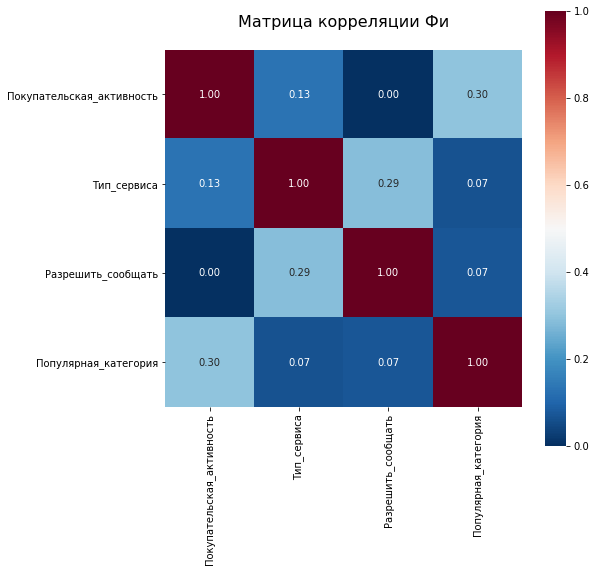

In [64]:
df_drop_phik = df.drop(['id', 
                        'Маркет_актив_6_мес', 
                        'Маркет_актив_тек_мес', 
                        'Длительность', 
                        'Акционные_покупки', 
                        'Средний_просмотр_категорий_за_визит', 
                        'Неоплаченные_продукты_штук_квартал', 
                        'Ошибка_сервиса', 'Страниц_за_визит', 
                        'Выручка_предыдущий_месяц', 
                        'Выручка_препредыдущий_месяц',
                        'Выручка_текущий_месяц',
                        'минут_предыдущий_месяц',
                        'минут_текущий_месяц'
                       ], axis=1)

figsize = (8,8)
fig, ax = plt.subplots(figsize=figsize)
plt.title('Матрица корреляции Фи'+'\n',size=(16))

sns.heatmap(df_drop_phik.phik_matrix(), ax=ax, annot=True, fmt='.2f', cmap="RdBu_r", square=True) 
plt.show()

В категориальных переменных неплохо связаны Популярная категория с Покупательской активностью а Разрешить сообщать с Типом сервиса.

### Диаграммы

Теперь посмотрим на диаграммы рассеяния.

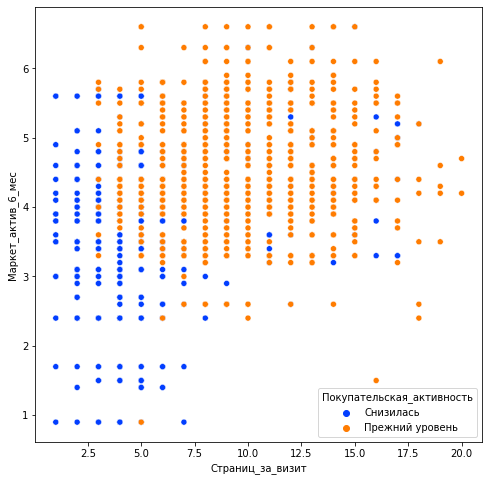

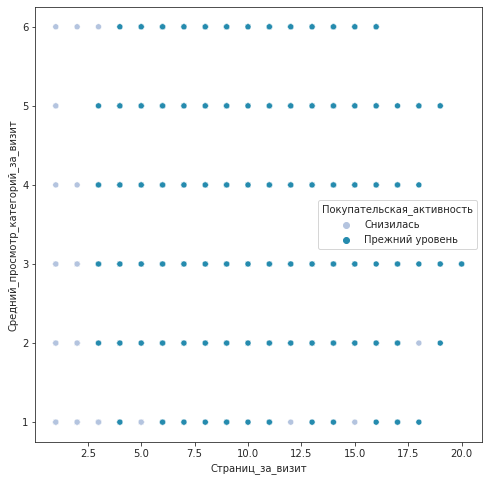

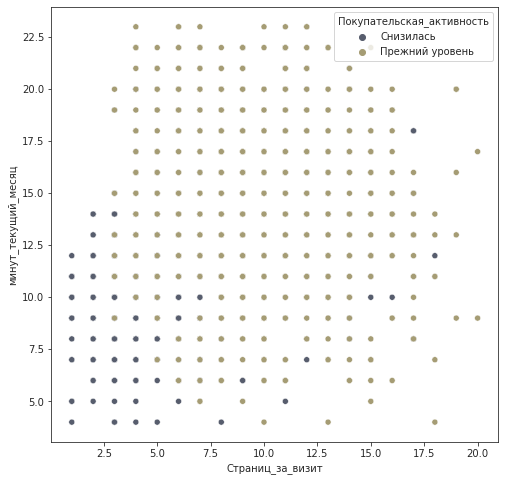

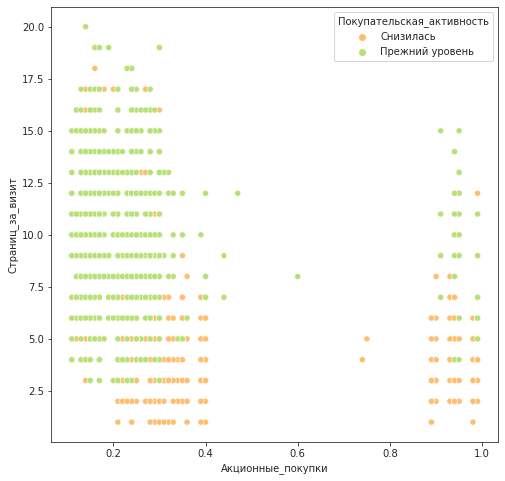

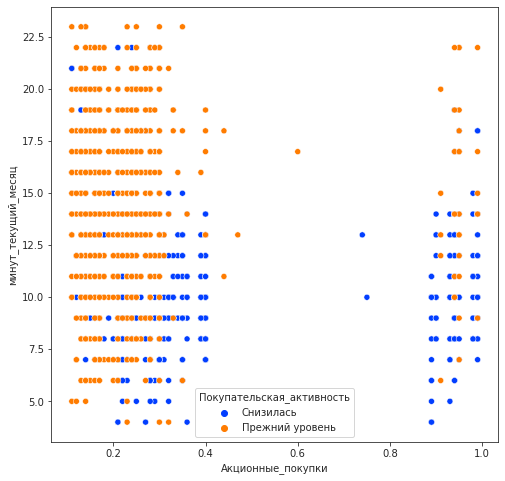

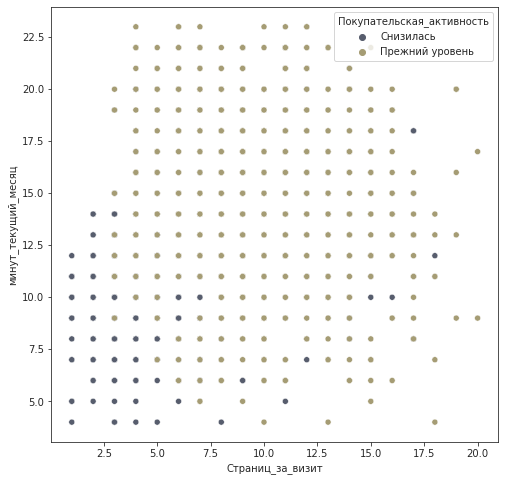

In [65]:
fig, axes = plt.subplots(figsize = (8,8)) 
sns.scatterplot(
    x='Страниц_за_визит',
    y='Маркет_актив_6_мес', 
    data=df_dropid,
    palette='bright',
    hue='Покупательская_активность', 
    ax=axes, 
    )

sns.set_style('ticks')

fig, axes = plt.subplots(figsize = (8,8)) 
sns.scatterplot(
    x='Страниц_за_визит',
    y='Средний_просмотр_категорий_за_визит', 
    data=df_dropid,
    palette='PuBuGn',
    hue='Покупательская_активность', 
    ax=axes, 
    )

sns.set_style('ticks')

fig, axes = plt.subplots(figsize = (8,8)) 
sns.scatterplot(
    x='Страниц_за_визит',
    y='минут_текущий_месяц', 
    data=df_dropid,
    palette='cividis',
    hue='Покупательская_активность', 
    ax=axes, 
    )

sns.set_style('ticks')

fig, axes = plt.subplots(figsize = (8,8)) 
sns.scatterplot(
    x='Акционные_покупки',
    y='Страниц_за_визит', 
    data=df_dropid,
    palette='RdYlGn',
    hue='Покупательская_активность', 
    ax=axes, 
    )

sns.set_style('ticks')

fig, axes = plt.subplots(figsize = (8,8)) 
sns.scatterplot(
    x='Акционные_покупки',
    y='минут_текущий_месяц', 
    data=df_dropid,
    palette='bright',
    hue='Покупательская_активность', 
    ax=axes, 
    )

sns.set_style('ticks')

fig, axes = plt.subplots(figsize = (8,8)) 
sns.scatterplot(
    x='Страниц_за_визит',
    y='минут_текущий_месяц', 
    data=df_dropid,
    palette='cividis',
    hue='Покупательская_активность', 
    ax=axes, 
    )

sns.set_style('ticks')

### Вывод по корреляционному анализу

Можно сказать, что чем больше пользователь просмотрел страниц на сайте, тем выше его активность, как минимум она не снижается. На это так же влияет количество маркетинговой активности. Тоже самое можно сказать и про категории, чем больше пользователь просмотрел категорий, соответственно больше пролистал страниц. Ровно как и потратил в целом время на сайт.

На графике Акционные_покупки-Страниц_за_визит видно деление на два сегмента. Часть находится в диапазоне от 0 доя 0.4 покупок, просматривая при этом до 20 страниц, а вторая чатсь находится от 0.9 до 1 покупки, просматривая до 15 покупок. Количество пользователей, тех, чья активность снизилась находятся в нижней части графика, они просматривают меньше страниц.

Аналогичный график Акционные_покупки-Время на сайте. Отличие в отображении большего количества пользователей чья активность снизилась.

Отличается график Акционные_покупки-Маркет_актив_6_мес. Имеется так же два провала, но при этом активность маркетинга до 2.5 отсутствует. Начинается от примерно 3.

*Мультиколлинеарностью* называют наличие коофицента корреляции в диапазоне от 0.95 до 1. При таких значениях матрицы признаков могут стать вырожденными, и тогда у системы линейных уравнений не будет одного решения. 
В датасете отсутствует мультиколлинеарность. У нас максимальные значения корреляции это 0.3-0.4.

# Использование пайпланов

### Создание пайплайна

Необходимо создать обучить четыре модели. Начнем с подготовки данных.

In [66]:
df_pred_lol = df.copy()
df_pred_lol

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [67]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(df.drop(['Покупательская_активность', 'id'], axis=1),
                                                    df['Покупательская_активность'],
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE,
                                                    stratify = df['Покупательская_активность'])

X_train_double = X_train.copy()
X_test_double = X_test.copy()


Для кодировки категориальных данных применим два кодировщика. Для столбца Популярная_категория - OrdinalEncoder.
Для всех остальных категориальных - OneHotEncoder.

Взглянем на количество значений в столбце Популярная категория.

In [68]:
df['Популярная_категория'].value_counts()

Товары для детей                        329
Домашний текстиль                       250
Косметика и аксесуары                   223
Техника для красоты и здоровья          183
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

Для линейной регрессии данное кодирование будет представляться лишним, так как модель увидит взаимосвязи, хотя их там нет. Для остальных моделей это не должно быть проблемой.

In [69]:
ohe_columns = [ 
    'Популярная_категория',
    'Разрешить_сообщать',
]

ord_columns = ['Тип_сервиса']

num_columns = ['Маркет_актив_6_мес', 
               'Маркет_актив_тек_мес', 
               'Длительность', 
               'Акционные_покупки', 
               'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал',
               'Ошибка_сервиса',
               'Страниц_за_визит',
               'Выручка_предыдущий_месяц',
               'Выручка_препредыдущий_месяц',
               'Выручка_текущий_месяц',
               'минут_предыдущий_месяц',
               'минут_текущий_месяц'
              ] 


Далее кодируем данные и заменяем пропуски, которые образовались после кодирования.

In [70]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    ) 

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[['премиум', 'стандарт']], handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]) 


Применим ColumnTransformer для объединения операций по подготовке данных в общий пайплайн.

In [71]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 


Кодируем целевой признак.

In [72]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

Итоговый пайплайн.

In [73]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Произведем поиск RandomizedSearchCV. Создадим словарь гиперпараметров для каждой модели.

In [74]:
param = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(kernel='poly', probability= True, random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,
                                      solver='liblinear', 
                                      penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 


Перебираем и ищем модель. Используем метрику precision. Нам необходимо присваивать класс 1 без ошибок.

In [75]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param, 
    cv=5,
    scoring='precision',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=10
)

randomized_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['Популярная_категория',
                                                                                'Разрешить_сообщать']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImp...
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='precision')

Взглянем на поиск лучшей модели и метрику.

In [76]:
print('Метрика precision для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика precision для лучшей модели:
 0.8742512401352013

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Популярная_категория',
                                                   'Разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImp

Логистическая регрессия. Создадим датафрейм из результатов на каждую модель.

In [77]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

,rank_test_score,param_models,mean_test_score,params
0,1,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.874251,"{'preprocessor__num': MinMaxScaler(), 'models__C': 4, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
9,2,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.869762,"{'preprocessor__num': StandardScaler(), 'models__C': 4, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
1,3,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.866062,"{'preprocessor__num': StandardScaler(), 'models__C': 3, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
4,4,KNeighborsClassifier(),0.826223,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 3, 'models': KNeighborsClassifier()}"
2,5,KNeighborsClassifier(),0.803831,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 1, 'models': KNeighborsClassifier()}"
5,6,DecisionTreeClassifier(random_state=42),0.775744,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
3,7,DecisionTreeClassifier(random_state=42),0.773792,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
8,8,DecisionTreeClassifier(random_state=42),0.725993,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
6,9,DecisionTreeClassifier(random_state=42),0.719063,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
7,10,DecisionTreeClassifier(random_state=42),0.609415,"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"


Выведем предсказания.

In [79]:
y_test_pred = randomized_search.best_estimator_.predict(X_test)
print(f'Предсказание на тестовой выборке: {y_test_pred}')

Предсказание на тестовой выборке: [0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0
 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0
 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1
 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0
 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1]


Проверим на метриках. Для поиска модели мы указали в гиперпараметрах метрику precision.

In [80]:
print('Метрика precision на тестовой выборке:', precision_score(y_test, y_test_pred, pos_label=0))
print('Метрика recall на тестовой выборке:', recall_score(y_test, y_test_pred, pos_label=0))
print('Метрика accuracy на тестовой выборке:', accuracy_score(y_test, y_test_pred))

Метрика precision на тестовой выборке: 0.9009433962264151
Метрика recall на тестовой выборке: 0.9502487562189055
Метрика accuracy на тестовой выборке: 0.9046153846153846


Самый большой результат показала метрика recall.

### Предсказания

Самое время применить модель к основным данным. Создадим столбец Предсказание активности, чтобы каждый пользователь получил статус будущей финансовой активности.

In [81]:
df_pred = df.drop(['id', 'Покупательская_активность'], axis=1)

df['Предсказание_активности'] = randomized_search.best_estimator_.predict(df_pred)
df.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Предсказание_активности
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,1
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,0
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,1
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,1
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,1


Посчитаем количество пользователей в столбце.

In [82]:
df['Предсказание_активности'].value_counts()

0    868
1    429
Name: Предсказание_активности, dtype: int64

Имеем такие показатели из 1297 пользователей:

Прежний уровень    868 | 66%

Снизилась          429 | 33%

### Выводы о построении моделей и результатов предсказания

Прежде чем создавать модель - мы выполнили ее поиск.

Поиск осущствлялся через создание системы пайплайнов.

Сначала разбили датафрейм на выборки, исключив из моделирования столбец id.

Осуществили кодировку категориальных и количественных признаков.
Для категориальных применили OneHotEncoder, а для признака Тип сервиса - OrdinalEncoder.

Был создан трансформатор ColumnTransformer со всеми нужными столбцами и кодировщиками.

В итоговый пайплайн вложили модель Дерево решений.

Поиск осуществлялся с помощью RandomizedSearchCV. Ему был передан словарь со следующими моделями и их гиперпараметрами:
- KNeighborsClassifier
- DecisionTreeClassifier
- SVC
- LogisticRegression

Поиск показал что лучшая модель LogisticRegression с регулированием L1 и С равным 4.

Задем мы обучили модель на тренировочных данных и применили ее к тестовым. Метрики показали следующее:
Метрика precision на тестовой выборке: 0.90
Метрика recall на тестовой выборке: 0.95
Метрика accuracy на тестовой выборке: 0.90

Метрика recall показала самый большой результат.

Следующий шаг - применить модель непосредственно к прогнозированию финансовой активности.
Для этого был создан отдельный столбец Предсказание активности, который показывает, в какую сторону будет двигаться пользователь в своем интересе к сайту.

Из всех 1297 пользователей датасета:

Прежний уровень 868 | 66%

Снизилась 429 | 33%


# Анализ важности признаков

Построим различные диаграммы с помощью метода SHAP, для анализа вклада каждого признака. Продублируем модель для вставки в функции графиков.

In [83]:
df_copy = df.copy()
df = df.drop(['id', 'Покупательская_активность', 'Предсказание_активности'], axis=1)

pipe_cls = randomized_search.best_estimator_['preprocessor']
pipe_model = randomized_search.best_estimator_['models']


In [84]:
display(pipe_cls.fit_transform(df, y_train).shape)

(1297, 20)

In [85]:
df.shape

(1297, 16)

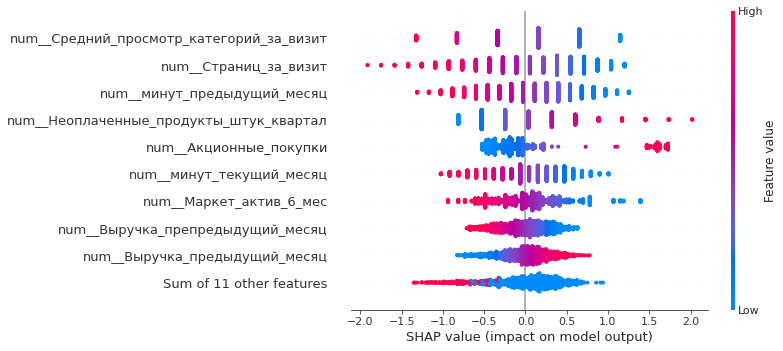

In [86]:
feature_names = pipe_cls.get_feature_names_out().tolist() 
explainer = shap.LinearExplainer(pipe_model, pipe_cls.fit_transform(df, y_train), feature_names= feature_names)
shap_values = explainer(pipe_cls.fit_transform(df, y_train))

shap.plots.beeswarm(shap_values)

Признак категорий за визит является самым весомым. Далее идет просмотор Страниц за визит и время на сайте.

Взглянем на индивидуальные SHAP-значения каждого наблюдения в датасете.

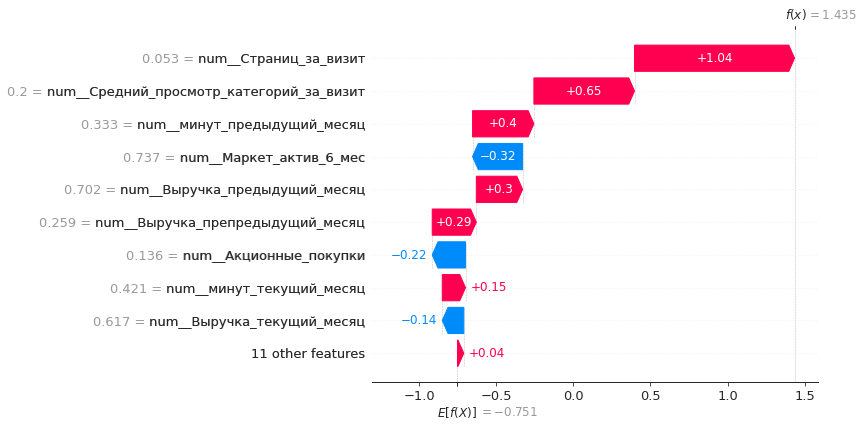

In [88]:
shap.plots.waterfall(shap_values[5]) 

Сильнее всего на его классификацию влияет признак Страниц за визит: он «перетягивает» предсказание в сторону класса 1.
Лишь три категориии тянутся к классу 0.

Посмотрим на общий вклад признаков в прогнозы модели и средние SHAP-значения признака по всем наблюдениям. 

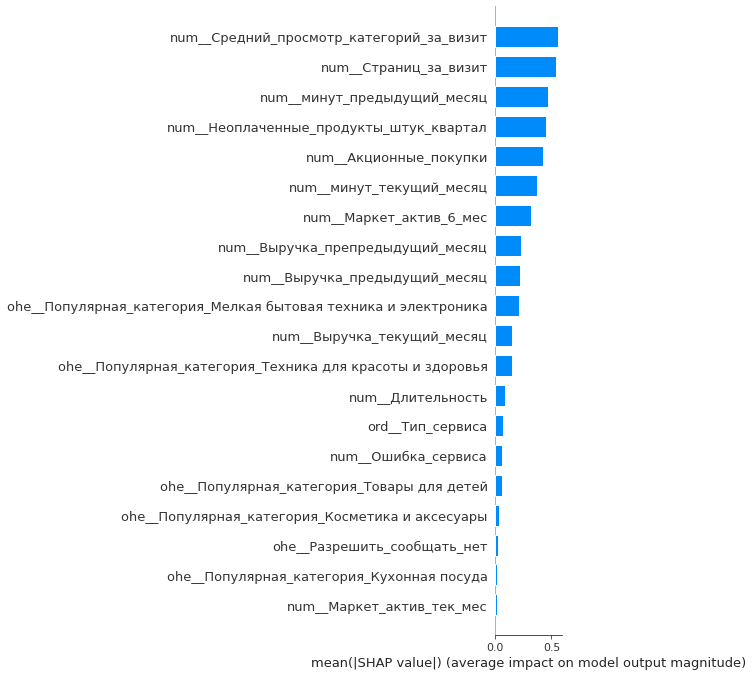

In [89]:
shap.summary_plot(shap_values, plot_type="bar", max_display=20)

Здесь, как и на первом графике, первая тройка это Средний просмотр категорий за визит, Страниц за визит и время на сайте.

### Выводы о значимости признаков

Везде будем рассматривать 5ый объект.

На первой диаграмме видно, что Страниц за визит, Средний просмотро категорий за визит и время на сайте являются наиболее весомыми в определеннии прогноза модели.

Длинные хвосты влево и вправо говорят нам о том, что признак склоняет модель отнести объект как к классу 0 так и к 1. У одного из признаков эти хвосты длиннее чем правые.

Между тем, сами линии достаточно толстые, это значит что сгруппировано очень много наблюдений в конкретном признаке.

У признака Страниц за визит в левом хвосте очень красные точки, это значит что сам признак больше по оси Х.

Интересный признак Акционные покупки, его красные точки расположены справа, почти у края значения 2. Больше половины всех значений этого признака отнесены к первому классу.
Неоплаченные продукты штук квартал имеет тоже много значений отнесенных к классу 1 чем к классу 0.

Теперь второй график, показывающий индивидуальные SHAP-значения каждого наблюдения.

Самое большое влияние на классификацию оказывает признак Средний просмотр категорий за визит. Он перетягивает предсказание в сторону класса 1.
Лишь небольшое количество положительных значений у Маркет актив 6 мес, Акционные покупки и Выручка склоняют к 0.

На третьем графике показывается общий вклад признаков.

Как и в первом графике, Страниц за визит, Средний просмотр категорий за визит и время на сайте имеют самый весомый вклад в предсказание.
На втором месте Неоплаченные продукты, Акционные покупки и Маркет актив.

Не имеют влияния на прогнозирование такие признаки как Маркет актив мес, Категория продуктов.




# Сегментация покупателей

Проведем сегментацию покупателей, для этого будем использовать результаты моделирования и данные о прибыльности покупателей. 
Для начала присоединим к основному датафрейму четвертый, с данными о прибыльности.

Зафиксируем размерность.

In [90]:
df_copy.shape

(1297, 19)

Присоединим оставшийся датафрейм

In [91]:
df_copy = df_copy.merge(money, on='id', how='outer')
df_copy.head(5)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Предсказание_активности,Прибыль
0,215349,Снизилась,премиум,да,4.4,4.0,819.0,0.75,Товары для детей,4.0,4.0,2.0,5.0,5216.0,4472.0,4971.6,12.0,10.0,1.0,4.16
1,215350,Снизилась,стандарт,нет,4.9,3.0,539.0,0.14,Домашний текстиль,5.0,2.0,1.0,5.0,5457.5,4826.0,5058.4,8.0,13.0,0.0,3.13
2,215351,Снизилась,стандарт,да,3.2,5.0,896.0,0.99,Товары для детей,5.0,0.0,6.0,4.0,6158.0,4793.0,6610.4,11.0,13.0,1.0,4.87
3,215352,Снизилась,стандарт,нет,5.1,3.0,1064.0,0.94,Товары для детей,3.0,2.0,3.0,2.0,5807.5,4594.0,5872.5,8.0,11.0,1.0,4.21
4,215353,Снизилась,стандарт,да,3.3,4.0,762.0,0.26,Домашний текстиль,4.0,1.0,1.0,4.0,4738.5,5124.0,5388.5,10.0,10.0,1.0,3.95


In [92]:
df_copy.shape

(1300, 20)

Все в порядке, можно проводить сегментацию.

Нас интересует прибыль, активность. Выберем сегмент пользователей на основе двух значений. Из этого сегмента выберем группу.

In [97]:
df_copy.dropna(inplace=True)
model_preds = randomized_search.best_estimator_.predict_proba(df_copy)
df_copy['Вероятность_снижения'] = model_preds[:,1]
display(df_copy.head())


,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,...,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Предсказание_активности,Прибыль,Вероятность_снижения
0,215349,Снизилась,премиум,да,4.4,4.0,819.0,0.75,Товары для детей,4.0,...,2.0,5.0,5216.0,4472.0,4971.6,12.0,10.0,1.0,4.16,0.897028
1,215350,Снизилась,стандарт,нет,4.9,3.0,539.0,0.14,Домашний текстиль,5.0,...,1.0,5.0,5457.5,4826.0,5058.4,8.0,13.0,0.0,3.13,0.379450
2,215351,Снизилась,стандарт,да,3.2,5.0,896.0,0.99,Товары для детей,5.0,...,6.0,4.0,6158.0,4793.0,6610.4,11.0,13.0,1.0,4.87,0.806575
3,215352,Снизилась,стандарт,нет,5.1,3.0,1064.0,0.94,Товары для детей,3.0,...,3.0,2.0,5807.5,4594.0,5872.5,8.0,11.0,1.0,4.21,0.964891
4,215353,Снизилась,стандарт,да,3.3,4.0,762.0,0.26,Домашний текстиль,4.0,...,1.0,4.0,4738.5,5124.0,5388.5,10.0,10.0,1.0,3.95,0.609311


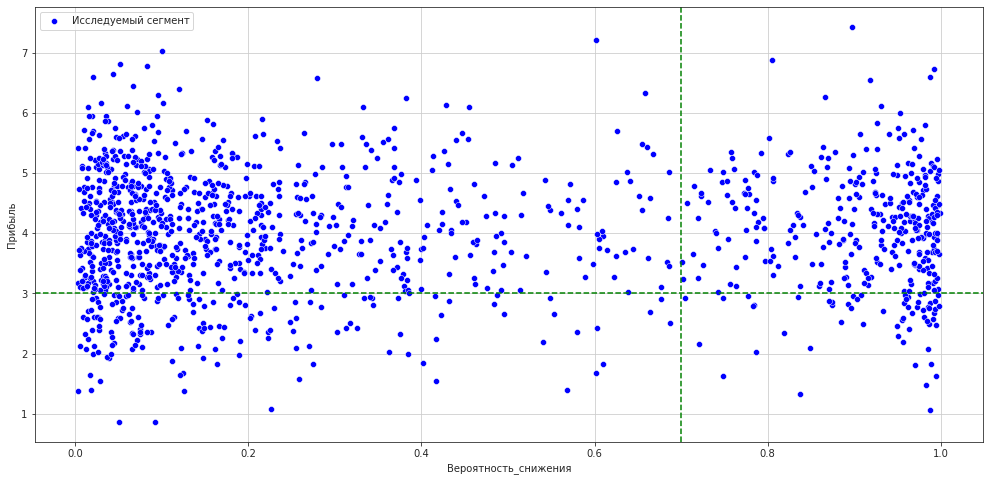

In [108]:
plt.figure(figsize=(17, 8))
sns.scatterplot(data=df_copy, x='Вероятность_снижения', y='Прибыль', label='Исследуемый сегмент', color='blue')
plt.legend()
plt.axvline(x=0.7, color='green', linestyle='--')
plt.axhline(y=3, color='green', linestyle='--')
plt.legend()
plt.grid(True)

Выделим пороги по вероятности снижения и по прибыли. Порог вероятности снижения возьмем за >0.7, а прибыль больше чем 3.

In [115]:
searching_clients = df_copy.query('Вероятность_снижения >= 0.7 & Прибыль >= 3')
searching_clients.head(5)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,...,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Предсказание_активности,Прибыль,Вероятность_снижения
0,215349,Снизилась,премиум,да,4.4,4.0,819.0,0.75,Товары для детей,4.0,...,2.0,5.0,5216.0,4472.0,4971.6,12.0,10.0,1.0,4.16,0.897028
2,215351,Снизилась,стандарт,да,3.2,5.0,896.0,0.99,Товары для детей,5.0,...,6.0,4.0,6158.0,4793.0,6610.4,11.0,13.0,1.0,4.87,0.806575
3,215352,Снизилась,стандарт,нет,5.1,3.0,1064.0,0.94,Товары для детей,3.0,...,3.0,2.0,5807.5,4594.0,5872.5,8.0,11.0,1.0,4.21,0.964891
5,215354,Снизилась,стандарт,да,5.1,3.0,431.0,0.23,Косметика и аксесуары,2.0,...,7.0,2.0,5685.0,4503.0,5869.6,11.0,12.0,1.0,3.62,0.806703
7,215356,Снизилась,стандарт,да,4.2,4.0,192.0,0.14,Косметика и аксесуары,2.0,...,1.0,3.0,4146.5,4433.0,4566.4,6.0,7.0,1.0,4.93,0.905816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,216564,Прежний уровень,стандарт,да,5.6,4.0,342.0,0.94,Кухонная посуда,2.0,...,5.0,8.0,4930.0,5269.0,4766.2,14.0,19.0,1.0,5.58,0.801758
1248,216599,Прежний уровень,стандарт,да,3.3,4.0,453.0,0.22,Техника для красоты и здоровья,2.0,...,8.0,8.0,4408.5,4428.0,4521.6,12.0,9.0,1.0,4.06,0.774688
1256,216607,Прежний уровень,стандарт,да,3.3,4.0,575.0,0.23,Товары для детей,2.0,...,5.0,8.0,4991.0,4463.0,5578.6,11.0,12.0,1.0,4.91,0.806609
1284,216635,Прежний уровень,стандарт,да,0.9,3.0,932.0,0.35,Косметика и аксесуары,3.0,...,8.0,5.0,4452.0,4980.0,5039.6,12.0,18.0,1.0,3.15,0.756811


Итого 310 клиентов. Проведем исследование этой группы. За основу группы возьмем признак Страниц_за_визит.

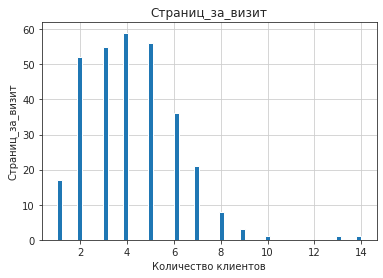

In [117]:
(searching_clients['Страниц_за_визит']
 .hist(bins=60)
 .set_title('Страниц_за_визит')
)

plt.xlabel('Количество клиентов')
plt.ylabel('Страниц_за_визит');

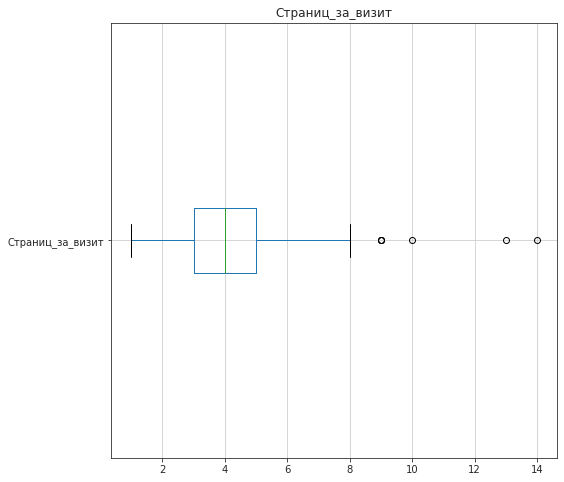

In [119]:
searching_clients['Страниц_за_визит'].plot.box(figsize=(8, 8), title='Страниц_за_визит', vert=False, grid=True)

plt.show()

In [ ]:
Сравним графики Страниц за визит у этой группы со Средний_просмотр_категорий_за_визит.

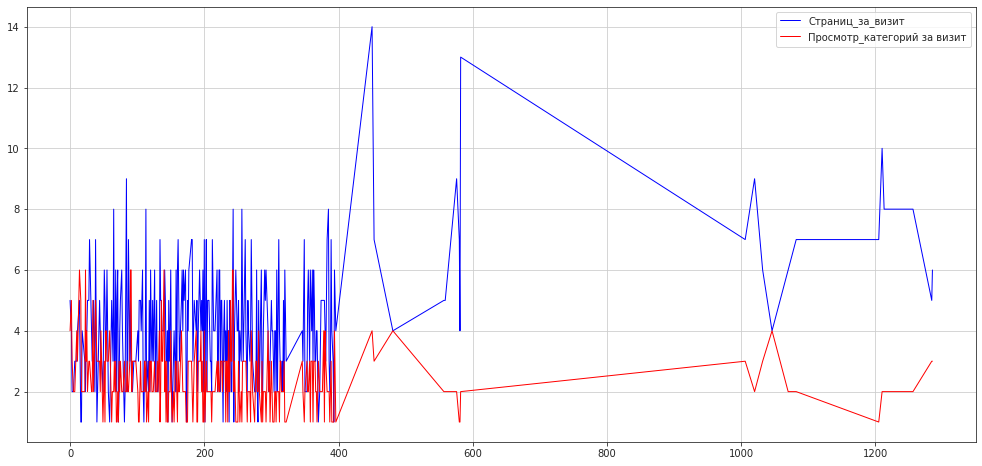

In [123]:
plt.figure(figsize=(17, 8))
searching_clients['Страниц_за_визит'].plot(lw=1, color='b', label="Страниц_за_визит")
searching_clients['Средний_просмотр_категорий_за_визит'].plot(lw=1, color='r', label="Просмотр_категорий за визит")
plt.legend()
plt.grid(True)

График показывает, что на лицо прямая зависимость, Страниц_за_визит от Просмотр_категорий за визит пользователя. Сначала идет блок высокой частоты, затем рваный период и снова высокой частоты на обоих графиках.

In [124]:
display(searching_clients['Страниц_за_визит'].describe())

display('Дисперсия:', np.var(searching_clients['Страниц_за_визит']).round(3))

display('Межквартильный размах:', stats.iqr(searching_clients[['Страниц_за_визит']]))

display('Размах:', searching_clients['Страниц_за_визит'].max()-searching_clients['Страниц_за_визит'].min())

display('Медиана:', searching_clients['Страниц_за_визит'].median())

count    310.000000
mean       4.170968
std        1.983703
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       14.000000
Name: Страниц_за_визит, dtype: float64

'Дисперсия:'

3.922

'Межквартильный размах:'

2.0

'Размах:'

13.0

'Медиана:'

4.0

Имеем среднее арифметическое 4.17 и медиану 4.0. Это хорошие показатели, они почти равные.
Дисперсия 3.92, средняя. Стандартное отклонение 1.98.
Минимальное и максимальное значения - 1 и 14 соответственно, размах 13.
Межвартильный размах 2.0.

Диаграмма размаха практически идеальный ящик с усами, но показывает определенные выбросы справа. Гистограмма достаточно правильный график нормального распределения, смещенный влево.

Сравним эту группу со всеми остальными.

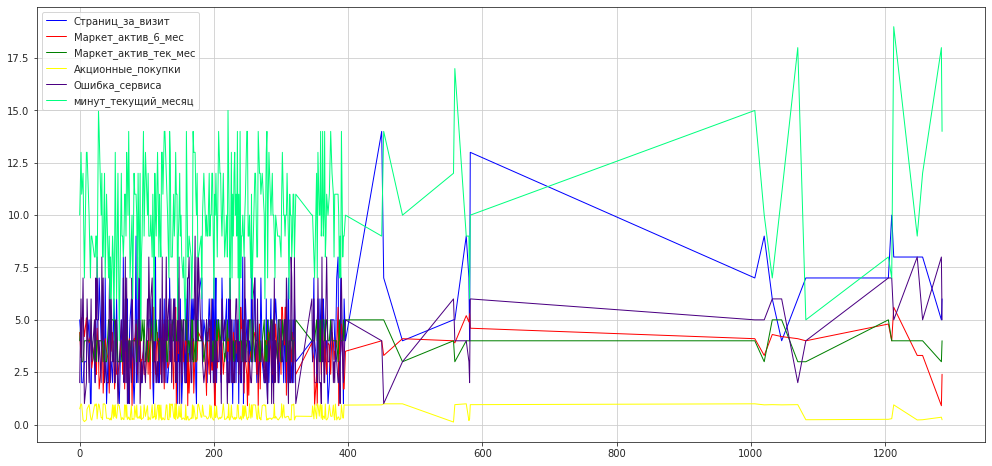

In [134]:
plt.figure(figsize=(17, 8))
searching_clients['Страниц_за_визит'].plot(lw=1, color='b', label="Страниц_за_визит")
searching_clients['Маркет_актив_6_мес'].plot(lw=1, color='r', label="Маркет_актив_6_мес")
searching_clients['Маркет_актив_тек_мес'].plot(lw=1, color='g', label="Маркет_актив_тек_мес")
searching_clients['Акционные_покупки'].plot(lw=1, color='yellow', label="Акционные_покупки")
searching_clients['Ошибка_сервиса'].plot(lw=1, color='indigo', label="Ошибка_сервиса")
searching_clients['минут_текущий_месяц'].plot(lw=1, color='springgreen', label="минут_текущий_месяц")
plt.legend()
plt.grid(True)

Практически все графики имеют схожую структуру.

Взглянем на то, какое количество пользователей из этой группы имеют статус На прежнем уровне в Покупательская_активность.

In [125]:
searching_clients.query('Покупательская_активность == "Прежний уровень"').count()

id                                     13
Покупательская_активность              13
Тип_сервиса                            13
Разрешить_сообщать                     13
Маркет_актив_6_мес                     13
Маркет_актив_тек_мес                   13
Длительность                           13
Акционные_покупки                      13
Популярная_категория                   13
Средний_просмотр_категорий_за_визит    13
Неоплаченные_продукты_штук_квартал     13
Ошибка_сервиса                         13
Страниц_за_визит                       13
Выручка_предыдущий_месяц               13
Выручка_препредыдущий_месяц            13
Выручка_текущий_месяц                  13
минут_предыдущий_месяц                 13
минут_текущий_месяц                    13
Предсказание_активности                13
Прибыль                                13
Вероятность_снижения                   13
dtype: int64

Всего 13 пользователя, 4 процента. Не сильно много, учитывая что это очень прибыльные клиенты.

In [126]:
searching_clients['Средний_просмотр_категорий_за_визит'].median()

2.0

In [127]:
searching_clients['Популярная_категория'].value_counts()

Товары для детей                        99
Косметика и аксесуары                   63
Домашний текстиль                       59
Кухонная посуда                         50
Техника для красоты и здоровья          25
Мелкая бытовая техника и электроника    14
Name: Популярная_категория, dtype: int64

С большим отрывом у этой группы пользователей в приоритете товары для детей и косметика и аксессуары. Их вообще практически не интересует мелка бытовая техника и электроника.

Предложения по группе пользователей.

Данная категория пользователей является самой прибыльной, и их интересует конкретная группа товаров. Они просматривает не больше 2 категорий товаров за визит. Значит они знают что хотят и заранее идут на интересующие их позиции товаров.
Для удержания этой группы пользователей необходимо расширить ассортимент интересующих их товаров, ввести скидки, и в целом усилить маркетинговую политику именно по этой группе товаров. Возможно остальные группы, приносящие меньший доход фирме предпочитают другие товары, но это уже зависит от выбранной стратегии, на какой группе нужно сконцентрировать внимание.

### Вывод по сегментации

Первым шагом было присоединение к основному нашему датасету 4ый - содержащий данные по прибыли.

Затем мы определили для себя сегмент, в отношении которой будем проводить исследование и давать рекомендации. Мы выбрали группу с Страниц_за_визит.

Составили гистограмму, диаграмму размаха и линейный график и провели статистическое исследование.

Выяснили, что у данной группы всего 4 процента пользователей не теряют интерес к сайту.

Определили, что для этой группы предпочтительные товары для детей и косметика и аксессуары.

Сформировали предложение.


# Итоговый вывод

К нам обратился магазин "В один клик" за помощью в удержании клиентов. Магазин занимается различными бытовыми и электронными товарами. В последнее время снизилась активность клиентов. Клиент уже проделал определенную работу, промаркировал клиентов классами покупательской активности, Не изменилось, Снизилась. Это очень хорошо и поможет нам в работе.

Наша задача состояла в том, чтобы из полученных данных построить модель, которая бы предсказывала статус клиента в течение трех месяцев, будет ли у клиента оставаться интерес к компании или же он начнет снижаться и компания рискует потерять клиента вовсе.

Проделана следующая работа:

- *После общего осмотра данных*, мы произвели их обработку. Датафреймы содержали незначительные артефакты, как наличие разделителя и точек в десятичных значениях. Изменены некоторые типы данных object в столбце Прибыль, на float. Произведен поиск дубликатов и пустых значений, коих не было обнаружено. Названия столбцов заменены на более удобные для обработки, введены нижние подчеркивания. В некоторых столбцах были схожие названия статусов типа сервиса и периодов. Было найден один выброс в столбце Выручка, в 106862.2 рублей, что сразу заменено на медианное по столбцу;

- *Статистическое исследование*. Для каждого столбца каждого датафрейма были найдены среднее, медиана, дисперсия, стандартное отклонение, межквартильный размах, минимальные и максимальные значения, их разность. Построены графики, диаграммы размаха (в почти каждом столбце были найдены аномальные значения), гистограммы для количественных признаков, столбчатые диаграммы для категориальных признаков. Один из столбцов в датафрейме имеет высокую дисперсию, большой разброс и разнородность данных. Большая часть, наоборот, имеет низкую дисперсию;

- *Корреляционный анализ*. Построена матрица корреляции Спирмана и Фи корреляции. Имеются положительные корреляции- Маркет актив 6 мес довольно неплохо коррелирует со Страниц за визит и со временем проведенным на сайте. Акционные покупки с Неоплаченными продуктами. Средний просмотр категорий со страницами за визит. Хорошая корреляция у Страниц за визит со временем на сайте - 0.45. Отрицательные корреляции -Маркет актив 6 мес с акционными покупками. Акционные покупки со Страницами за визит и временем на сайте У Среднего просмотра категорий с Неоплаченными продуктами. Тоже самое можно сказать и про категории, неплохо связаны Популярная категория с Покупательской активностью а Разрешить сообщать с Типом сервиса. Ровно как и потратил в целом время на сайт. На графике Акционные_покупки-Страниц_за_визит видно деление на два сегмента. Часть находится в диапазоне от 0 доя 0.4 покупок, просматривая при этом до 20 страниц, а вторая чатсь находится от 0.9 до 1 покупки, просматривая до 15 покупок. Количество пользователей, тех, чья активность снизилась находятся в нижней части графика, они просматривают меньше страниц.Отличается график Акционные_покупки-Маркет_актив6мес. Имеется так же два провала, но при этом активность маркетинга до 2.5 отсутствует. Начинается от примерно 3. Мультиколлинеарностью называют наличие коофицента корреляции в диапазоне от 0.95 до 1. При таких значениях матрицы признаков могут стать вырожденными, и тогда у системы линейных уравнений не будет одного решения. В датасете отсутствует мультиколлинеарность. У нас максимальные значения корреляции это 0.3-0.4;

- Объединение всех датафреймов в один.

Следующий шаг - *создание пайплайнов* и поиск лучшей модели.

Был построен пайплайн, и произведен поиск среди четырех моделей. Целевой признак Покупательская активность. Остальные признаки входные.

На вход пайплана подавались следующие модели и диапазоны их параметров:
- KNeighborsClassifier(n_neighbors=range(1, 7));
- DecisionTreeClassifier(max_depth=range(2, 6), max_features=range(2, 5));
- LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1');
- SVC(kernel='poly', random_state=RANDOM_STATE).

Разбиты на группы признаки, собраны в словари: ohe, ord, num. Для каждого обработчика своя категория.

Кодировка в пайплайне осуществлялась с помощью двух кодировщиков: OneHotEncoder и OrdinalEncoder. Первый задействован для кодировки бинарных значений, имеющих в столбцах всего по два строковых значения. Второй был примененм к столбцу Категория товаров. Так как категорий там 6, этот кодировщик лучше подходит.

Масштабирование в пайплайне сделано с помощью двух скэйлеров: StandartScaler() и MinMaxScaler(). Количественных признаков всего два.

В целом, в пайплане проделана следующая работа:
 - Присвоение целевого и входных признаков переменным у и Х;
 - Разбитие датафрейма на 4 выборки, входная тренировочная, входная тестовая, целевая тренировочная, целевая тестовая;
 - Кодирование категориальных признаков;
 - Масштабирование количественных;
 - Сборка столбцов и обработчиков с помощью трансформатора ColumnTransformer;
 - Создание итогового пайплана, куда включаются предподготовительные данные и трансформатор;

Затем мы осуществили поиск лучшей модели с помощью RandomizedSearchCV(). 
Лучшей моделью оказалась LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1', С=4).

С помощью метрик мы определили следующую точность модели:

Метрика precision на тестовой выборке: 90%
Метрика recall на тестовой выборке: 95%
Метрика accuracy на тестовой выборке: 90%

Самый большой результат показала метрика recall.

Модель была обучена на тестовых данных.

Последним шагом в данном разделе было прогнозирование на реальном датасете. Выявлены пользователи с потенциальными статусами в течение трех месяцев. Мы добавили еще один столбцев в датафрейм, куда добавили спрогнозированные данные.

В *анализе важности признаков*, использовались значения Шепли, оценка которых производилась с помощью метода SHAP. Мы использовали три различных графика, каждый из которых показывал определенную сторону вклада признаков. Везде рассматривали 5ый объект. На первой диаграмме видно, что Страниц за визит, Средний просмотро категорий за визит и время на сайте являются наиболее весомыми в определеннии прогноза модели. Длинные хвосты влево и вправо говорят нам о том, что признак склоняет модель отнести объект как к классу 0 так и к 1. У одного из признаков эти хвосты длиннее чем правые. Между тем, сами линии достаточно толстые, это значит что сгруппировано очень много наблюдений в конкретном признаке. У признака Страниц за визит в левом хвосте очень красные точки, это значит что сам признак больше по оси Х.

Интересный признак Акционные покупки, его красные точки расположены справа, почти у края значения 2. Больше половины всех значений этого признака отнесены к первому классу. Неоплаченные продукты штук квартал имеет тоже много значений отнесенных к классу 1 чем к классу 0.

Теперь второй график, показывающий индивидуальные SHAP-значения каждого наблюдения.

Самое большое влияние на классификацию оказывает признак Средний просмотр категорий за визит. Он перетягивает предсказание в сторону класса 1. Лишь небольшое количество положительных значений у Маркет актив 6 мес, Акционные покупки и Выручка склоняют к 0.

На третьем графике показывается общий вклад признаков.Как и в первом графике, Страниц за визит, Средний просмотр категорий за визит и время на сайте имеют самый весомый вклад в предсказание. На втором месте Неоплаченные продукты, Акционные покупки и Маркет актив.

Не имеют влияния на прогнозирование такие признаки как Тип Сервиса, Разрешение сообщать.

В *финальном шаге сегментации пользователей*, мы добавили четвертый датасет к общему.
Выделили сегмент пользователей с прибылью выше 3 и вероятностью снижения выше 0.7.
Произвели выбор группы, которая имела наибольшую прибыль и имела самой большой потенциал к снижению интереса к сайту. Таких пользователей набралось 310, или 23% от всех 1297.
За основу группы был взят признак Страниц_за_визит
Составили графики по данной группе пользователей, и выяснили, что Страниц_за_визит сильно коррелирует с Категорий за визит. Линейные графики практически идентичны. 
Сопоставили этот признак с остальными - получились практически идентичные графики во всем. От частоты до амплитуды.
Оказалось, что количество пользователей которые склонны покинуть сайт является 96%. Что очень много.
Затем, мы произвели поиск категорий товаров, изучив поведение прибыльной группы на сайте. Количество категорий товаров в среднем равно двум. Для этой группы пользователей предпчтительнее всего товары для детей и косметика и аксессуары. И их совсем не интересует электроника и бытовые приборы.

*Сформировали предложение для компании*, как удержать эту категорию пользователей. 
Данная категория пользователей является самой прибыльной, и их интересует конкретная группа товаров. Они просматривает не больше 2 категорий товаров за визит. Значит они знают что хотят и заранее идут на интересующие их позиции товаров. Для удержания этой группы пользователей необходимо расширить ассортимент интересующих их товаров, ввести скидки. Возможно остальные группы, приносящие меньший доход фирме предпочитают другие товары, но это уже зависит от выбранной стратегии, на какой группе нужно сконцентрировать внимание.

Добавим так же, что для удержания определенной группы пользователей, нужно создать целую маркетинговую стратегию. Невозможно использовать одни и те же методы для всех сегментов пользователей. У пользователей разный доход, разное образование, разное мышление, разный подход к потреблению и выбору товаров. Есть пользователи которые берут дешевые товары на последние деньги и есть другая крайняя категория - те, кто покупает ради покупки. Поэтому крайне важно досконально знать каждый сегмент своих клиентов. 

Возможно, стоит добавить больше признаков, таких как: 
- Оценка срока доставки товара;
- Были ли возвраты товара и как часто у каждого клиента;
- Оценка стоимости товаров, что очень сильно влияет на выручку;

У компании не все потеряно, но первые звоночки уже есть, и над этим необходимо усиленно работать. В первую очередь усилить рекламный нажим на конкретные группы пользователей.